<a href="https://colab.research.google.com/github/FireStrings/MasterDegree/blob/main/EDA/EDA_Brasilia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import os
os.chdir("/content/drive/My Drive/UFSCAR/Notebooks")

Mounted at /content/drive/


In [ ]:
estacao = "brasilia"

In [ ]:
%run UtilsNew.ipynb

In [ ]:
set_plot_size(15, 3)

###Check raw file

In [ ]:
raw_anual_df = load_files(estacao, False)

In [ ]:
raw_anual_df.head()

,Data,Hora (UTC),Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Ins. (C),Pto Orvalho Max. (C),Pto Orvalho Min. (C),Pressao Ins. (hPa),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Radiacao (KJ/m²),Chuva (mm)
0,01/01/2023,0,"20,1","20,9","20,0","87,0","91,0","87,0","17,9","19,2","17,8","887,7","887,7","887,2","1,2","187,0","3,3",NaN,"0,0"
1,01/01/2023,100,"19,2","20,1","19,2","90,0","90,0","87,0","17,5","17,8","17,4","888,1","888,1","887,7","0,8","153,0","2,9",NaN,"0,0"
2,01/01/2023,200,"19,3","19,5","19,0","90,0","90,0","89,0","17,6","17,8","17,3","887,8","888,1","887,8","1,5","145,0","2,5",NaN,"0,0"
3,01/01/2023,300,"19,3","19,4","19,1","91,0","91,0","90,0","17,7","17,8","17,5","887,8","887,9","887,7","1,4","162,0","3,2",NaN,"0,0"
4,01/01/2023,400,"19,7","19,7","19,1","90,0","91,0","90,0","18,1","18,1","17,4","887,6","887,9","887,6","2,7","140,0","5,7",NaN,"0,0"


In [ ]:
raw_anual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Data                  17544 non-null  object
 1   Hora (UTC)            17544 non-null  int64 
 2   Temp. Ins. (C)        17513 non-null  object
 3   Temp. Max. (C)        17505 non-null  object
 4   Temp. Min. (C)        17505 non-null  object
 5   Umi. Ins. (%)         17513 non-null  object
 6   Umi. Max. (%)         17505 non-null  object
 7   Umi. Min. (%)         17504 non-null  object
 8   Pto Orvalho Ins. (C)  17513 non-null  object
 9   Pto Orvalho Max. (C)  17505 non-null  object
 10  Pto Orvalho Min. (C)  17505 non-null  object
 11  Pressao Ins. (hPa)    17515 non-null  object
 12  Pressao Max. (hPa)    17507 non-null  object
 13  Pressao Min. (hPa)    17507 non-null  object
 14  Vel. Vento (m/s)      17509 non-null  object
 15  Dir. Vento (m/s)      17506 non-null

In [ ]:
total = len(raw_anual_df)
count_nulls = raw_anual_df[["Radiacao (KJ/m²)"]].notna().sum().sum()

print(total)
print(count_nulls)
print("Perc nulls:", round((count_nulls/total), 3))

17544
9370
Perc nulls: 0.534


###Check after pre processing

In [ ]:
df = load_files(estacao, True).set_index("data_hora", drop=False)

###Check the hour range

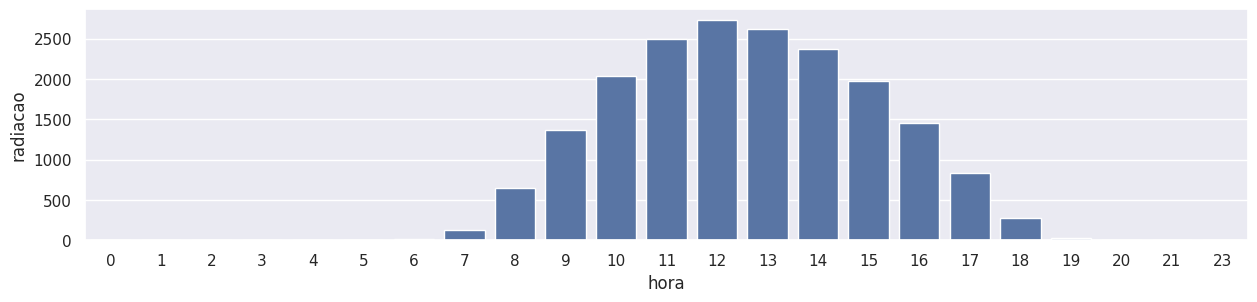

In [ ]:
plot_distrib_horario(df, None, estacao)

In [ ]:
start_hour = 7
end_hour = 18
df = filter_between(df, "hora", start_hour, end_hour)

###Time series

Whats the seasonal interval?

In [ ]:
intervalo_sazonal = get_seasonal_interval(df, start_hour)

In [ ]:
intervalo_sazonal

12

####Stationarity

#####Resample in days

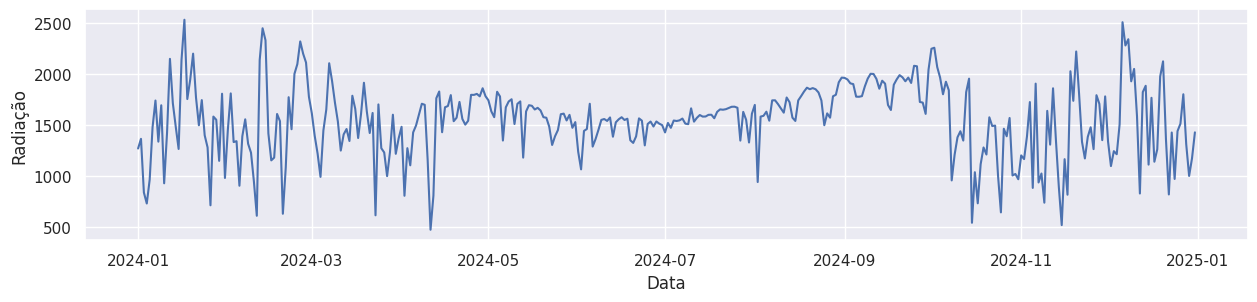

In [ ]:
df.rename(columns={"data_hora":"Data", "radiacao":"Radiação"}, inplace=True)
df_resampled = df[["Radiação", "Data"]].set_index("Data").resample("D").mean()
df_resampled = df_resampled.reset_index()
plot = sns.lineplot(data=df_resampled[df_resampled["Data"] >= "2024-01-01"], x="Data", y="Radiação")

#####Not resampled

<Axes: xlabel='data_hora', ylabel='radiacao'>

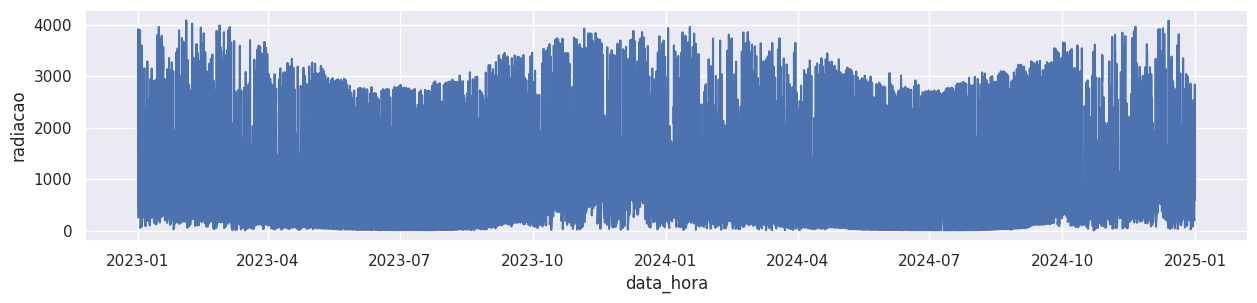

In [ ]:
sns.lineplot(data=df[["radiacao", "data_hora"]].set_index("data_hora"), x="data_hora", y="radiacao")

####Adfuler test

In [ ]:
adfuller_test(df[["radiacao", "data_hora"]].set_index("data_hora"))

Teste estatístico ADF : -10.531782744556157
p-valor : 9.112206707818808e-19
Num Lags : 37
Numero de observações : 8721
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


####Decomposition

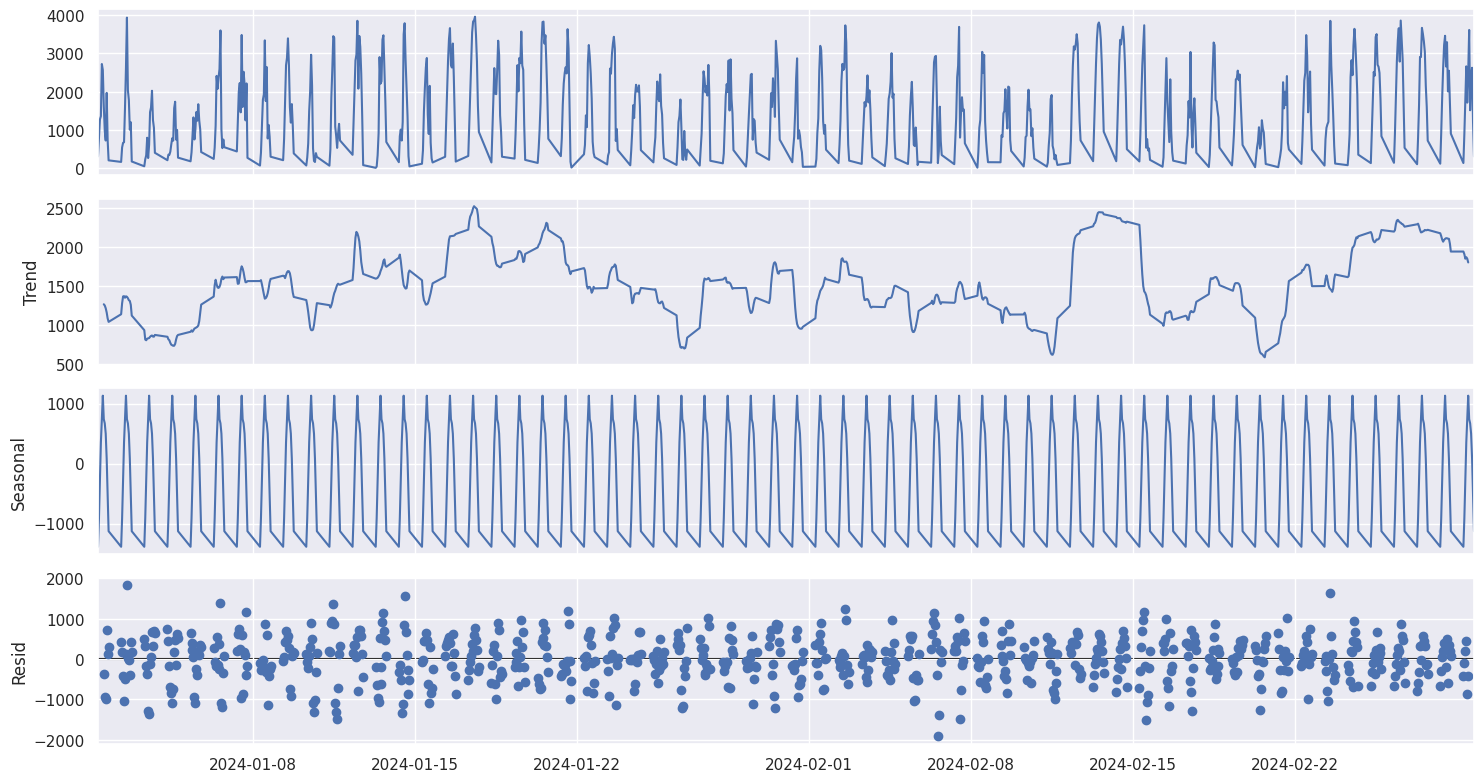

In [ ]:
set_plot_size(15, 8)

df_dec = df[["Radiação", "Data"]]
df_dec = filter_between(df_dec, "Data", "2024-01-01", "2024-03-01").set_index('Data')

# A variancia não muda ao longo do tempo, a sazonalizadade nao acompanha a tendencia, por isso o modelo aditivo
resultado = seasonal_decompose(df_dec, model="addictive", period=intervalo_sazonal)
ax = resultado.plot()

####ACF and PACF

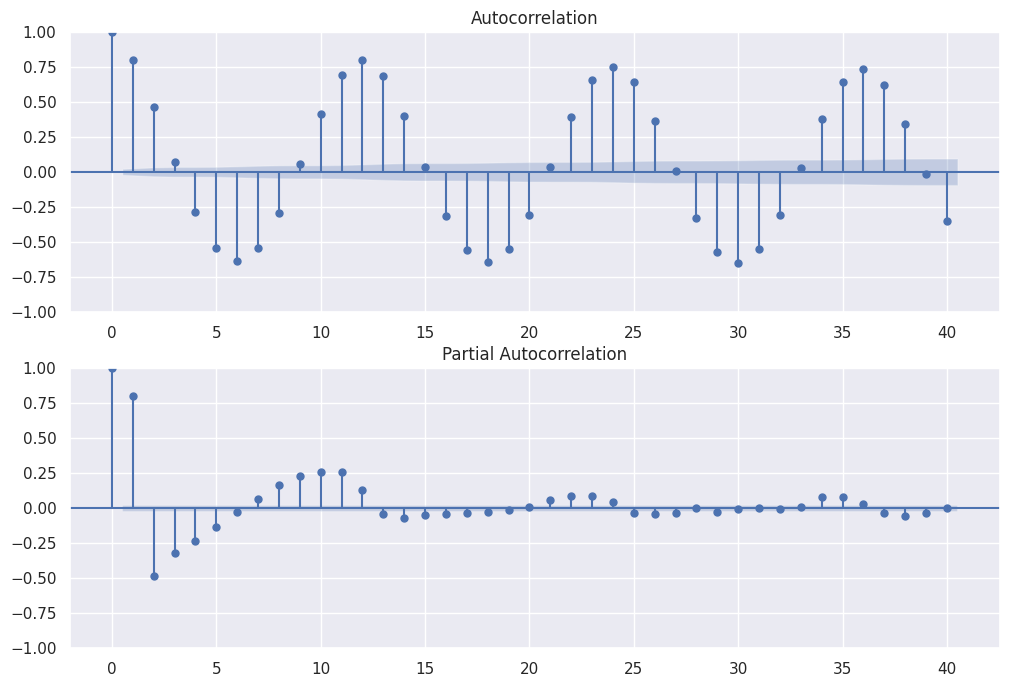

In [ ]:
calculate_acf_pacf(df)